## Load packages and data

In [ ]:
%pip install --quiet ucimlrepo sentence_transformers umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
# install packages
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import umap
import sklearn

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# import data
df = pd.read_csv("/content/BP_AR_3514.1_cleaned.csv")

## Keyword Indicator Analysis

In [ ]:
# load model
embedding_model =  SentenceTransformer("all-MiniLM-L6-v2")

# create function
def get_embedding(text):
  """
  Get embeddings for a string, If the input is not a string, return a zero vector.
  """
  if not isinstance(text, str):
    return np.zeros(384)
  return embedding_model.encode(text)

df['BP_Embedding'] = df['BP3514.1: PDF Text'].apply(get_embedding)
df['AR_Embedding'] = df['AR3514.1: PDF Text'].apply(get_embedding)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# define indicator keywords
keywords = {
    "HVAC": ['HVAC systems', 'air conditioning upgrades', 'energy-efficient HVAC school buildings'],
    "indoor_air_quality": ['indoor air quality', 'air filtration systems', 'healthy air school initiative', 'indoor environmental quality initiative'],
    "energy_efficiency": ['school energy conservation programs', 'energy-saving initiatives', 'energy efficiency'],
}

# define function
def get_similarity(embedding, keywords):
  """
  Calculate similarity between a text embedding and a list of key phrase embeddings.
  """
  keyword_embeddings = [get_embedding(keyword) for keyword in keywords]
  similarities = [cosine_similarity(embedding.reshape(1, -1), keyword_embedding.reshape(1, -1))[0][0] for keyword_embedding in keyword_embeddings]
  return np.mean(similarities)

# apply similarity calculation for each indicator
for indicator, keywords in keywords.items():
  df[f"{indicator}_similarity"] = df['BP_Embedding'].apply(lambda x: get_similarity(x, keywords))


### Preprocessing for Regression Analysis

In [ ]:
# subset data for analysis
reg_df = df[['BP 3514.1 Year Adopted', 'District Type', 'HVAC_similarity',
             'HVAC: AC', '2023-24 Student Enrollment', 'indoor_air_quality_similarity',
             'energy_efficiency_similarity', 'Indoor Air Quality', 'Energy Efficiency']].copy()

# rename columns
reg_df.rename({'BP 3514.1 Year Adopted': 'year_adopted',
                'District Type': 'district_type',
                'HVAC: AC': 'HVAC_indicator',
                '2023-24 Student Enrollment': 'student_enrollment',
                'Indoor Air Quality': 'indoor_air_quality',
                'Energy Efficiency': 'energy_efficiency'},
               axis=1, inplace=True)


# encode categorical columns
categorical_columns = ['district_type']
reg_df = pd.get_dummies(reg_df, columns=categorical_columns, drop_first=True, dtype=int)

### HVAC: AC Indicator Regression Analysis

                            OLS Regression Results                            
Dep. Variable:         HVAC_indicator   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.339
Date:                Wed, 15 Jan 2025   Prob (F-statistic):              0.254
Time:                        23:01:00   Log-Likelihood:                -476.90
No. Observations:                 684   AIC:                             963.8
Df Residuals:                     679   BIC:                             986.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

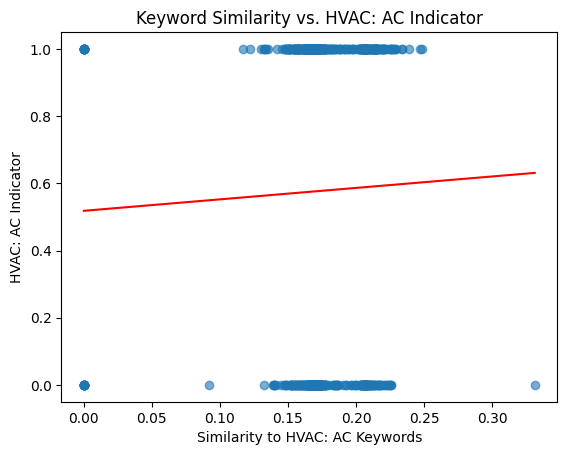

In [ ]:
# more renaming
reg_df.rename({'district_type_High School District': 'district_type_High_School_District',
                'district_type_Unified School District': 'district_type_Unified_School_District'},
               axis=1, inplace=True)

# fit model
model_ols_HVAC = smf.ols('HVAC_indicator~HVAC_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_HVAC.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['HVAC_similarity'], reg_df['HVAC_indicator'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['HVAC_similarity'].min(), reg_df['HVAC_similarity'].max(), 100)  # Range of the predictor
y = model_ols_HVAC.params['Intercept'] + model_ols_HVAC.params['HVAC_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to HVAC: AC Keywords')
plt.ylabel('HVAC: AC Indicator')
plt.title('Keyword Similarity vs. HVAC: AC Indicator')
plt.show()

### Indoor Air Quality Indicator Regression Analysis

                            OLS Regression Results                            
Dep. Variable:     indoor_air_quality   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.425
Date:                Wed, 15 Jan 2025   Prob (F-statistic):             0.0469
Time:                        23:01:00   Log-Likelihood:                -489.29
No. Observations:                 684   AIC:                             988.6
Df Residuals:                     679   BIC:                             1011.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

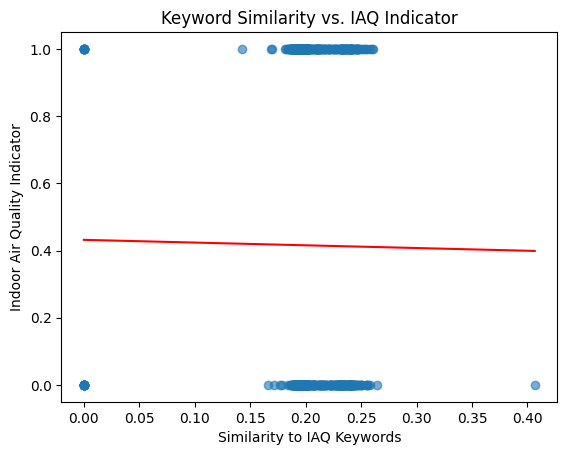

In [ ]:
# fit model
model_ols_IAQ = smf.ols('indoor_air_quality~indoor_air_quality_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_IAQ.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['indoor_air_quality_similarity'], reg_df['indoor_air_quality'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['indoor_air_quality_similarity'].min(), reg_df['indoor_air_quality_similarity'].max(), 100)  # Range of the predictor
y = model_ols_IAQ.params['Intercept'] + model_ols_IAQ.params['indoor_air_quality_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to IAQ Keywords')
plt.ylabel('Indoor Air Quality Indicator')
plt.title('Keyword Similarity vs. IAQ Indicator')
plt.show()

### Energy Efficiency Indicator Regression Analysis

                            OLS Regression Results                            
Dep. Variable:      energy_efficiency   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.689
Date:                Wed, 15 Jan 2025   Prob (F-statistic):             0.0303
Time:                        23:01:01   Log-Likelihood:                -512.12
No. Observations:                 714   AIC:                             1034.
Df Residuals:                     709   BIC:                             1057.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

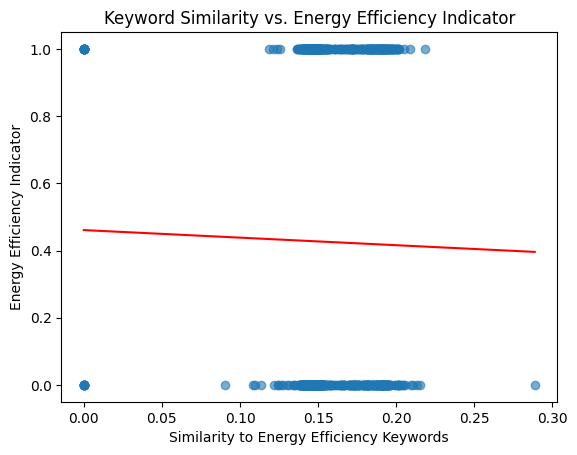

In [ ]:
# fit model
model_ols_ee = smf.ols('energy_efficiency~energy_efficiency_similarity + student_enrollment + district_type_High_School_District + district_type_Unified_School_District', data=reg_df).fit()
print(model_ols_ee.summary())

# Plot scatter plot: cosine similarty (x-axis) vs. sustainability score
plt.scatter(reg_df['energy_efficiency_similarity'], reg_df['energy_efficiency'], alpha=0.6)
# Generate values for the line of best fit
x = np.linspace(reg_df['energy_efficiency_similarity'].min(), reg_df['energy_efficiency_similarity'].max(), 100)  # Range of the predictor
y = model_ols_ee.params['Intercept'] + model_ols_ee.params['energy_efficiency_similarity'] * x  # Best-fit line equation
# Plot the line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel('Similarity to Energy Efficiency Keywords')
plt.ylabel('Energy Efficiency Indicator')
plt.title('Keyword Similarity vs. Energy Efficiency Indicator')
plt.show()

In [ ]:
# recreate same analyses for AR

## Mild/Medium/Spicy Language Analysis

### Strategy 1: Minimizing Hazardous Substances

In [ ]:
# create copy of df
lang_df_1 = df.copy()

# create dictionary for mild/medium/spicy language
language_dict = {
    "mild_1": "Insofar as reasonably possible, the Superintendent or designee shall minimize the quantities of hazardous substances stored and used on school property. When hazardous substances must be used, the Superintendent or designee shall give preference to materials that cause the least risk to people and the environment",
    "medium_1": "The Superintendent or designee will actively reduce the inventory of hazardous substances on school premises through systematic reviews, aiming for significant reductions annually. Any necessary hazardous materials will be vetted, ensuring that only the least harmful, and in the smallest quantities possible, are used. There will also be an increased push towards finding sustainable and non-hazardous alternatives for essential tasks",
    "spicy_1": "Championing a vision of a near-zero hazardous material environment, the Superintendent or designee will implement progressive strategies to phase out the presence of hazardous substances on school property. Every decision involving hazardous materials will be scrutinized, with an active drive towards adopting innovative, eco-friendly alternatives. The district will recognize and reward for their efforts in minimizing hazardous materials, fostering a competitive yet collaborative spirit among all district institutions towards achieving this goal",
    "mild_2": "The Superintendent or designee shall ensure that all potentially hazardous substances on district properties are inventoried, used, stored, and regularly disposed of in a safe and legal manner. The Superintendent or designee shall develop, implement, and maintain a written hazard communication program in accordance with 8 CCR 5194 and shall ensure that employees, students, and others as necessary are fully informed about the properties and potential hazards of substances to which they may be exposed.",
    "spicy_2": "The Superintendent or designee will commit to pioneering a holistic and transparent approach to hazardous material management. Leveraging advanced technology, the district will utilize digital platforms for real-time tracking, monitoring, and alerts related to hazardous substances. The detailed hazard communication program will not only comply with the standards of 8 CCR 5194 but also seek to set industry benchmarks. The Superintendent will ensure that all students, faculty, staff and administrators are fully informed and aware of potential exposure to hazardous materials and that there is a district-wide culture of safety, awareness, and proactive care when it comes to hazardous materials.",
    "mild_3": "The Superintendent or designee shall develop specific measures to ensure the safety of students and staff in school laboratories where hazardous chemicals are used. Such measures shall include the development and implementation of a chemical hygiene plan in accordance with 8 CCR 5191 and instruction to students about proper handling of hazardous substances. Teachers shall instruct students about the importance of proper handling, storage, disposal and protection when using any potentially hazardous substance pursuant to procedures and protocols referenced in AR 5142 under lab safety.",
    "spicy_3": "The Superintendent or designee will introduce a proactive system of periodic reviews and updates to the chemical hygiene plan, ensuring that it remains at the forefront of safety standards. All lab personnel and students will undergo regular refresher training sessions, covering technicalities of handling hazardous chemicals associated with AR 5142 and the underlying reasons for each safety measure. Moreover, digital safety platforms will be explored for real-time monitoring and initiating an alert protocol in accordance with the 8 CCR 5191 chemical hygiene plan. Partnerships with local safety organizations will be established to bring in external expertise around chemical usage, storage, and disposal and regularly audit the district's safety protocols.",
}

# clean text
def clean_pdf_text(text):
    """
    Cleans up textual data by lowercasing all letters, removing punctuation, removing stop words,
    and lemmatizing.
    """
    text = re.sub(r'Education code.*$', '', text, flags=re.IGNORECASE)
    text = re.sub(r'legal reference.*', '', text, flags=re.IGNORECASE | re.DOTALL) # Use regex to remove 'legal reference' and everything after
    text = text.lower() # Lowercase text
    tokens = word_tokenize(text) # Tokenize text
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)] # Regular expression to match punctuation
    stop_words = set(stopwords.words('english')) # Define stop words
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmetize
    cleaned_text = ' '.join(tokens) # Join tokens back into a string

    return cleaned_text

# apply function
language_dict = dict((temperature, clean_pdf_text(language)) for temperature, language in language_dict.items())

# apply similarity function (defined above)
for temperature, language in language_dict.items():
  lang_df_1[f"{temperature}_similarity"] = lang_df_1['BP_Embedding'].apply(lambda x: get_similarity(x, [language]))

In [ ]:
lang_df_1 = lang_df_1.rename({"District Name": "district_name",
                  "District-Wide Campus Sustainability Indicators (up to 3)": "sustainability_score"},
                             axis=1)

### Strategy 1: Minimizing Hazardous Materials: Spicy Language Analysis

In [ ]:
spicy_df_1 = lang_df_1[["spicy_1_similarity", "district_name", "sustainability_score"]]
most_spicy_1 = spicy_df_1.sort_values(by='spicy_1_similarity', ascending=False).head(20)
most_spicy_1

,spicy_1_similarity,district_name,sustainability_score
656,0.649744,Mountain Valley Unified,0.50
375,0.644357,Riverside Unified,1.00
231,0.644130,Santa Monica-Malibu Unified,3.00
529,0.643761,Gilroy Unified,1.00
644,0.643629,Yuba City Unified,0.00
481,0.642901,Lucia Mar Unified,3.00
401,0.642824,Alta Loma Elementary,3.00
622,0.642491,Cotati-Rohnert Park Unified,0.50
410,0.641954,Helendale Elementary,1.50
361,0.641830,Rocklin Unified,2.25


                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                  0.004108
Date:                  Wed, 15 Jan 2025   Prob (F-statistic):              0.949
Time:                          23:01:50   Log-Likelihood:                -1057.0
No. Observations:                   714   AIC:                             2118.
Df Residuals:                       712   BIC:                             2127.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

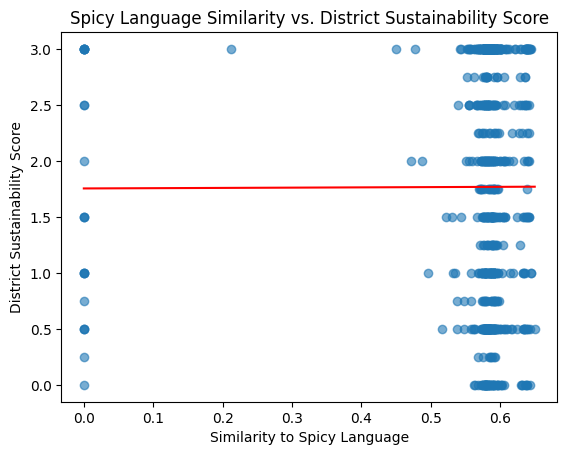

In [ ]:
# ols model
model_ols_spicy1 = smf.ols("sustainability_score ~ spicy_1_similarity", data=spicy_df_1).fit()
print(model_ols_spicy1.summary())

# plot scatter plot
plt.scatter(spicy_df_1['spicy_1_similarity'], spicy_df_1['sustainability_score'], alpha=0.6)

# generate line of best fit
x = np.linspace(spicy_df_1['spicy_1_similarity'].min(), spicy_df_1['spicy_1_similarity'].max(), 100)
y = model_ols_spicy1.params['Intercept'] + model_ols_spicy1.params['spicy_1_similarity'] * x
plt.plot(x, y, color='red', label='Line of Best Fit')

# add labels, title, and legend
plt.xlabel('Similarity to Spicy Language')
plt.ylabel('District Sustainability Score')
plt.title('Spicy Language Similarity vs. District Sustainability Score')
plt.show()

### Strategy 1: Minimizing Hazardous Materials: Medium Language Analysis


In [ ]:
medium_df_1 = lang_df_1[["medium_1_similarity", "district_name", "sustainability_score"]]
most_medium_1 = medium_df_1.sort_values(by='medium_1_similarity', ascending=False).head(20)
most_medium_1

,medium_1_similarity,district_name,sustainability_score
342,0.715183,Magnolia Elementary,3.00
163,0.709004,Island Union Elementary,2.00
333,0.704259,Buena Park Elementary,1.25
437,0.703538,Encinitas Union Elementary,0.50
568,0.702905,North Cow Creek Elementary,0.00
311,0.702832,Pacific Grove Unified,2.00
617,0.701234,Two Rock Union,0.75
481,0.698204,Lucia Mar Unified,3.00
132,0.697083,Di Giorgio Elementary,1.50
60,0.695798,Placerville Union Elementary,2.50


                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                 3.150e-05
Date:                  Wed, 15 Jan 2025   Prob (F-statistic):              0.996
Time:                          23:01:50   Log-Likelihood:                -1057.0
No. Observations:                   714   AIC:                             2118.
Df Residuals:                       712   BIC:                             2127.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

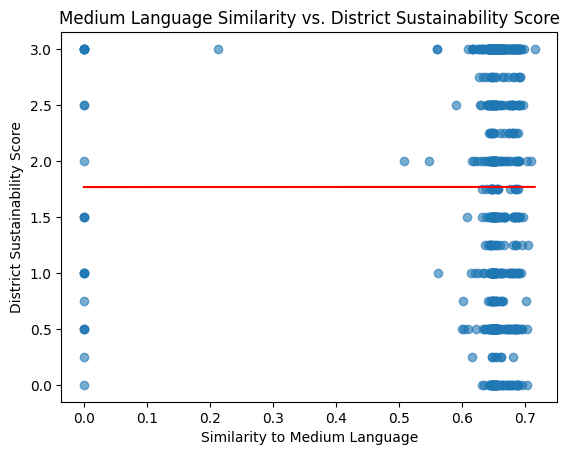

In [ ]:
# ols model
model_ols_medium1 = smf.ols("sustainability_score ~ medium_1_similarity", data=medium_df_1).fit()
print(model_ols_medium1.summary())

# plot scatter plot
plt.scatter(medium_df_1['medium_1_similarity'], medium_df_1['sustainability_score'], alpha=0.6)

# generate line of best fit
x = np.linspace(medium_df_1['medium_1_similarity'].min(), medium_df_1['medium_1_similarity'].max(), 100)
y = model_ols_medium1.params['Intercept'] + model_ols_medium1.params['medium_1_similarity'] * x
plt.plot(x, y, color='red', label='Line of Best Fit')

# add labels, title, and legend
plt.xlabel('Similarity to Medium Language')
plt.ylabel('District Sustainability Score')
plt.title('Medium Language Similarity vs. District Sustainability Score')
plt.show()

### Strategy 1: Minimizing Hazardous Materials: Mild Language Analysis

In [ ]:
mild_df_1 = lang_df_1[["mild_1_similarity", "district_name", "sustainability_score"]]
most_mild_1 = mild_df_1.sort_values(by='mild_1_similarity', ascending=False).head(20)
most_mild_1

,mild_1_similarity,district_name,sustainability_score
323,0.797671,Pope Valley Union Elementary,2.50
488,0.797630,Brisbane Elementary,1.25
78,0.797150,Westside Elementary,1.50
481,0.795833,Lucia Mar Unified,3.00
616,0.795481,Twin Hills Union Elementary,2.25
355,0.794721,Placer Hills Union Elementary,0.00
710,0.794429,Woodland Joint Unified,1.00
406,0.793499,Colton Joint Unified,2.50
494,0.793072,Millbrae Elementary,2.00
599,0.792921,Geyserville Unified,1.50


                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                   0.04840
Date:                  Wed, 15 Jan 2025   Prob (F-statistic):              0.826
Time:                          23:01:50   Log-Likelihood:                -1057.0
No. Observations:                   714   AIC:                             2118.
Df Residuals:                       712   BIC:                             2127.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         

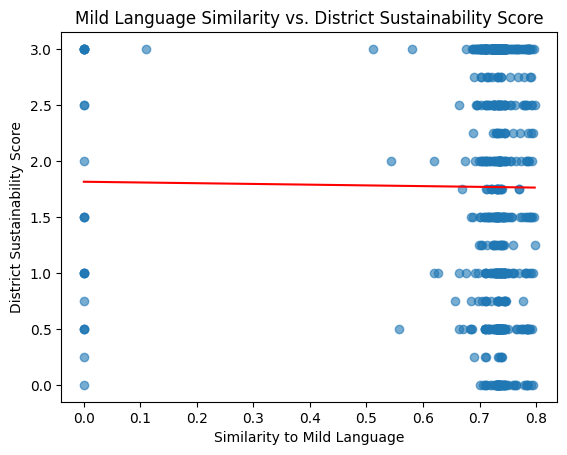

In [ ]:
# ols model
model_ols_mild1 = smf.ols("sustainability_score ~ mild_1_similarity", data=mild_df_1).fit()
print(model_ols_mild1.summary())

# plot scatter plot
plt.scatter(mild_df_1['mild_1_similarity'], mild_df_1['sustainability_score'], alpha=0.6)

# generate line of best fit
x = np.linspace(mild_df_1['mild_1_similarity'].min(), mild_df_1['mild_1_similarity'].max(), 100)
y = model_ols_mild1.params['Intercept'] + model_ols_mild1.params['mild_1_similarity'] * x
plt.plot(x, y, color='red', label='Line of Best Fit')

# add labels, title, and legend
plt.xlabel('Similarity to Mild Language')
plt.ylabel('District Sustainability Score')
plt.title('Mild Language Similarity vs. District Sustainability Score')
plt.show()

### Scoville Scale Language Menu Regression

                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.6722
Date:                  Wed, 15 Jan 2025   Prob (F-statistic):              0.696
Time:                          23:01:51   Log-Likelihood:                -1054.6
No. Observations:                   714   AIC:                             2125.
Df Residuals:                       706   BIC:                             2162.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

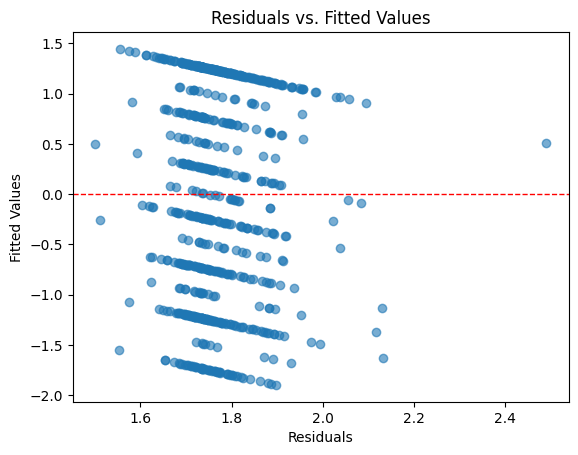

In [ ]:
# ols model
model_ols_language = smf.ols("sustainability_score ~ mild_1_similarity + medium_1_similarity + spicy_1_similarity + mild_2_similarity + spicy_2_similarity + mild_3_similarity + spicy_3_similarity", data=lang_df_1).fit()
print(model_ols_language.summary())

# Plot residuals
plt.scatter(model_ols_language.fittedvalues, model_ols_language.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

## Clustering Analysis

In [ ]:
# create a dataframe from the embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

df_copy = df.copy()
df_copy = df_copy.dropna(subset=['BP3514.1: PDF Text'])

# subset column and drop null values
bp = df_copy['BP3514.1: PDF Text'].tolist()

# Use `embedding_model` to create an embedding for each text
bp_embeddings = pd.DataFrame(embedding_model.encode(bp, random_state=211))
bp_embeddings = bp_embeddings.rename(lambda x: f"embedding_dim_{x}", axis=1)
bp_embeddings = bp_embeddings.assign(district = df_copy['District Name'].tolist())
bp_embeddings = bp_embeddings.assign(score = df_copy['District-Wide Campus Sustainability Indicators (up to 3)'].tolist())
bp_embeddings

,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,embedding_dim_5,embedding_dim_6,embedding_dim_7,embedding_dim_8,embedding_dim_9,...,embedding_dim_376,embedding_dim_377,embedding_dim_378,embedding_dim_379,embedding_dim_380,embedding_dim_381,embedding_dim_382,embedding_dim_383,district,score
0,0.027145,0.026765,0.023745,-0.016723,0.007943,0.008345,0.004084,0.047243,-0.073210,0.007636,...,-0.045146,0.007648,0.012078,-0.055559,0.084688,0.063487,0.053519,-0.017872,Alameda Unified,3.00
1,0.017107,0.029209,-0.006730,-0.019127,0.009102,0.016719,-0.011475,0.035407,-0.094626,0.028578,...,-0.020631,0.007470,0.003616,-0.042322,0.067639,0.045470,0.018766,0.004408,Castro Valley Unified,3.00
2,-0.008442,0.031047,0.017647,-0.000879,0.007878,0.015422,0.023117,0.023093,-0.106454,0.022303,...,-0.013970,-0.008724,-0.045461,-0.054825,0.083908,0.022450,0.046701,0.010871,Emery Unified,2.50
3,0.006834,0.032758,0.022364,-0.002563,0.012644,0.008335,0.036023,0.008773,-0.089770,0.019888,...,0.000309,0.004988,-0.049934,-0.062523,0.082352,0.031599,0.048553,0.006015,Hayward Unified,3.00
4,0.024867,0.027852,0.016417,-0.015943,0.006846,0.006356,0.007536,0.043645,-0.079372,0.013477,...,-0.041972,-0.000838,0.016891,-0.041969,0.088308,0.069753,0.055686,-0.026037,Livermore Valley Joint Unified,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.006809,0.043646,-0.005332,-0.031347,-0.002682,0.014547,-0.008022,0.028219,-0.079036,0.015849,...,-0.016851,0.007362,0.004762,-0.032704,0.066210,0.064269,0.035949,-0.004234,Winters Joint Unified,0.50
687,0.019264,0.040894,0.036906,-0.043009,0.007048,0.014586,-0.007784,0.007497,-0.095512,0.017478,...,-0.011923,0.018456,-0.026187,-0.065247,0.087861,0.067040,0.027241,-0.006945,Woodland Joint Unified,1.00
688,0.001657,0.022055,0.025595,0.006702,0.013928,0.017488,0.000889,0.010204,-0.099228,0.019488,...,-0.010355,-0.002934,-0.040511,-0.042966,0.087922,0.024502,0.048022,0.005130,Marysville Joint Unified,1.50
689,0.012471,0.025737,0.023105,-0.022704,-0.003024,0.005244,0.010815,0.039728,-0.076160,0.008442,...,-0.029425,0.008917,0.009320,-0.049684,0.089649,0.064716,0.057246,-0.026958,Plumas Lake Elementary,0.50


In [ ]:
# Initialize the umap reducer object
reducer = umap.UMAP(n_components=2)
embedding_columns = [c for c in bp_embeddings.columns if c not in ('district', 'score')]

# Fit the reducer
reducer.fit(bp_embeddings[embedding_columns])

# Transform the embeddings
embeddings_2dim_df = pd.DataFrame(reducer.transform(bp_embeddings[embedding_columns]))
embeddings_2dim_df['district'] = bp_embeddings['district']
embeddings_2dim_df['score'] = bp_embeddings['score']
embeddings_2dim_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1,district,score
0,14.544694,15.089357,Alameda Unified,3.00
1,7.060501,-1.395220,Castro Valley Unified,3.00
2,-5.398328,1.739719,Emery Unified,2.50
3,-5.222365,2.358928,Hayward Unified,3.00
4,15.291478,14.820866,Livermore Valley Joint Unified,2.50
...,...,...,...,...
686,5.404544,-0.101768,Winters Joint Unified,0.50
687,-3.564966,14.652372,Woodland Joint Unified,1.00
688,-5.332896,1.963108,Marysville Joint Unified,1.50
689,16.778231,7.190367,Plumas Lake Elementary,0.50


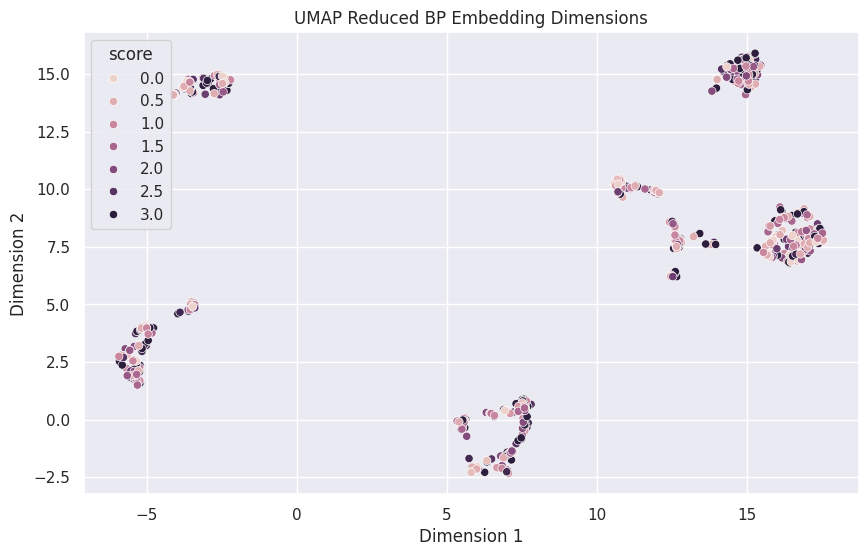

In [ ]:
# plot the umap reduced embedding dimensions; set hue to sustainability score
ax = sns.scatterplot(embeddings_2dim_df, x=0, y=1, hue='score')
plt.title('UMAP Reduced BP Embedding Dimensions')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.set_theme(rc={'figure.figsize':(10, 6)})

The clusters do not appear to have anything to do with the sustainability scores. The groups are distinct because their embeddings are similar, but I can conclude that similar embeddings do not result in similar sustainability scores.

In [ ]:
# repeat for AR
df_copy_ar = df.copy()
df_copy_ar = df_copy_ar.dropna(subset=['AR3514.1: PDF Text'])

# subset column and drop null values
ar = df_copy_ar['AR3514.1: PDF Text'].tolist()

# Use `embedding_model` to create an embedding for each text
ar_embeddings = pd.DataFrame(embedding_model.encode(ar, random_state=211))
ar_embeddings = ar_embeddings.rename(lambda x: f"embedding_dim_{x}", axis=1)
ar_embeddings = ar_embeddings.assign(district = df_copy_ar['District Name'].tolist())
ar_embeddings = ar_embeddings.assign(score = df_copy_ar['District-Wide Campus Sustainability Indicators (up to 3)'].tolist())
ar_embeddings

,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,embedding_dim_5,embedding_dim_6,embedding_dim_7,embedding_dim_8,embedding_dim_9,...,embedding_dim_376,embedding_dim_377,embedding_dim_378,embedding_dim_379,embedding_dim_380,embedding_dim_381,embedding_dim_382,embedding_dim_383,district,score
0,0.003661,-0.006978,-0.028346,0.055356,0.041708,0.049867,0.000117,0.041025,-0.075770,0.022151,...,-0.017825,0.054200,0.036906,-0.059244,0.092784,0.002371,0.034275,-0.036674,Alameda Unified,3.00
1,-0.028349,-0.047528,0.037953,0.009464,0.058888,0.030968,0.005069,0.006371,-0.085941,-0.007512,...,-0.021683,0.027687,0.015279,-0.049629,0.106939,0.006503,0.059962,-0.031255,Castro Valley Unified,3.00
2,0.011295,-0.039231,0.043900,0.018014,0.066286,0.029243,0.022094,-0.000074,-0.068157,-0.017328,...,-0.024838,0.005245,0.035425,-0.026220,0.114039,0.014564,0.086448,-0.034929,Emery Unified,2.50
3,0.007466,-0.025510,0.037301,0.015788,0.067581,0.013216,0.042669,-0.018265,-0.077760,-0.025436,...,-0.012286,0.000575,0.032264,-0.021194,0.102544,0.004571,0.088270,-0.021229,Hayward Unified,3.00
4,-0.008689,0.019923,-0.041902,0.026360,0.069281,0.028894,0.014875,0.077134,-0.070800,0.012222,...,-0.016326,0.035147,0.003469,-0.036258,0.027287,0.025092,0.036519,-0.049917,Livermore Valley Joint Unified,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,-0.027835,0.030395,-0.004203,-0.001447,0.030348,0.005794,0.024648,0.016385,-0.096594,-0.035221,...,-0.004046,-0.000046,-0.001411,-0.015516,0.069455,0.066633,0.056831,-0.024086,Winters Joint Unified,0.50
642,0.000217,-0.019517,-0.020529,0.042086,0.054740,0.055486,0.025480,0.039375,-0.076029,0.024725,...,-0.012067,0.051002,0.016407,-0.053960,0.079565,0.012849,0.038101,-0.041772,Woodland Joint Unified,1.00
643,0.012398,-0.039851,0.042652,0.018222,0.066318,0.028799,0.023350,0.000416,-0.068643,-0.017149,...,-0.025318,0.005150,0.035566,-0.026796,0.115094,0.012172,0.086184,-0.030554,Marysville Joint Unified,1.50
644,-0.005072,-0.022511,-0.023380,0.047831,0.063266,0.046856,0.026831,0.040545,-0.078017,0.019736,...,-0.015210,0.057891,0.030512,-0.039580,0.084680,0.021773,0.037608,-0.038306,Plumas Lake Elementary,0.50


In [ ]:
embedding_columns_ar = [c for c in ar_embeddings.columns if c not in ('district', 'score')]

# Fit the reducer
reducer.fit(ar_embeddings[embedding_columns_ar])

# Transform the embeddings
embeddings_2dim_df_ar = pd.DataFrame(reducer.transform(ar_embeddings[embedding_columns_ar]))
embeddings_2dim_df_ar['district'] = ar_embeddings['district']
embeddings_2dim_df_ar['score'] = ar_embeddings['score']
embeddings_2dim_df_ar

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1,district,score
0,1.684136,0.444636,Alameda Unified,3.00
1,8.887907,6.321827,Castro Valley Unified,3.00
2,14.690778,8.520655,Emery Unified,2.50
3,10.118137,10.689322,Hayward Unified,3.00
4,-0.036461,16.075129,Livermore Valley Joint Unified,2.50
...,...,...,...,...
641,10.236661,9.151295,Winters Joint Unified,0.50
642,-0.857033,-3.646905,Woodland Joint Unified,1.00
643,14.515950,8.876028,Marysville Joint Unified,1.50
644,-8.060812,-3.424401,Plumas Lake Elementary,0.50


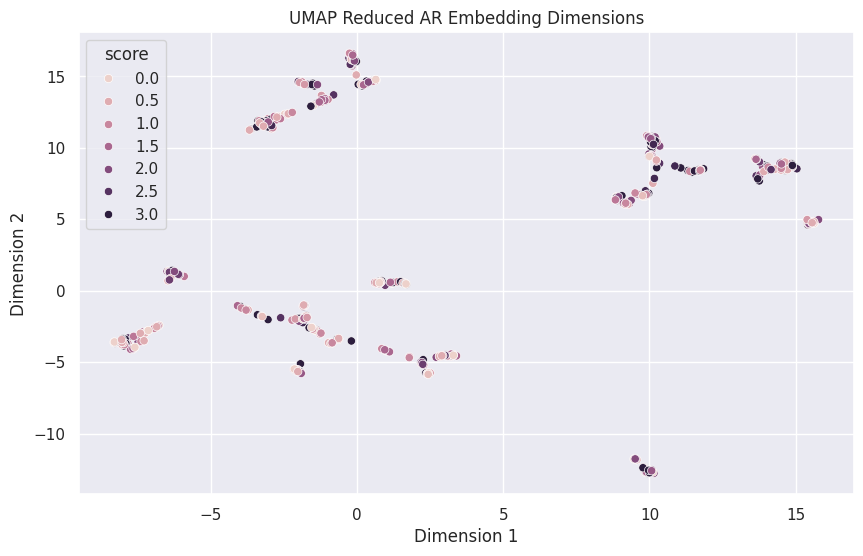

In [ ]:
 # plot the umap reduced embedding dimensions; set hue to sustainability score
ax = sns.scatterplot(embeddings_2dim_df_ar, x=0, y=1, hue='score')
plt.title('UMAP Reduced AR Embedding Dimensions')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.set_theme(rc={'figure.figsize':(10, 6)})

## Looking at School Scale

In [ ]:
df_scale = df.copy()
df_scale

,Unnamed: 0,CDS Code,County,District Name,Locale Classifications,District Type,2023-24 Student Enrollment,2023-24 % Unduplicated,BP: 3514.1 Hazardous Substances,BP 3514.1 Year Adopted,...,Environmental and Climate Action Score (20 points),BP3514.1: Path to PDF,BP3514.1: PDF Text,AR3514.1: Path to PDF,AR3514.1: PDF Text,BP_Embedding,AR_Embedding,HVAC_similarity,indoor_air_quality_similarity,energy_efficiency_similarity
0,0,1611190000000,Alameda,Alameda Unified,Suburban,Unified School District,10557,41,1,2009,...,14.00,Alameda_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Alameda_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[0.027144851, 0.026765319, 0.023745148, -0.016...","[0.0036611452, -0.0069777523, -0.028345602, 0....",0.164160,0.195070,0.145688
1,1,1611500000000,Alameda,Castro Valley Unified,Suburban,Unified School District,9489,43,1,2018,...,10.50,Castro_Valley_Unified_BP3514_1.pdf,book board policy section 3000 business nonins...,Castro_Valley_Unified_AR3514_1.pdf,book board policy section 3000 business nonins...,"[0.017107012, 0.029209051, -0.0067299437, -0.0...","[-0.02834926, -0.047528133, 0.037952736, 0.009...",0.211796,0.246902,0.186869
2,2,1611680000000,Alameda,Emery Unified,Suburban,Unified School District,600,81,1,2004,...,6.00,Emery_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Emery_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[-0.008442073, 0.031047137, 0.017647425, -0.00...","[0.011294531, -0.039230812, 0.043900095, 0.018...",0.154177,0.203331,0.169900
3,3,1611920000000,Alameda,Hayward Unified,Suburban,Unified School District,20190,82,1,1991,...,8.50,Hayward_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Hayward_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[0.0068334425, 0.032758046, 0.022363871, -0.00...","[0.007465541, -0.025510348, 0.037300568, 0.015...",0.169818,0.221454,0.188075
4,4,1612000000000,Alameda,Livermore Valley Joint Unified,Urban,Unified School District,13019,27,1,2009,...,11.00,Livermore_Valley_Joint_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Livermore_Valley_Joint_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[0.024867032, 0.027851533, 0.016417317, -0.015...","[-0.008689207, 0.01992316, -0.041902374, 0.026...",0.162774,0.194602,0.150826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,709,57727020000000,Yolo,Winters Joint Unified,Town,Unified School District,2279,58,1,2001,...,3.50,Winters_Joint_Unified_BP3514_1.pdf,business noninstructional operation bp 35141 h...,Winters_Joint_Unified_AR3514_1.pdf,business noninstructional operation ar 35141 h...,"[0.0068090823, 0.043645594, -0.005331632, -0.0...","[-0.027834674, 0.030394584, -0.0042025573, -0....",0.211566,0.239650,0.184478
710,710,57727100000000,Yolo,Woodland Joint Unified,Suburban,Unified School District,9483,77,1,2016,...,6.50,Woodland_Joint_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Woodland_Joint_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[0.019263843, 0.040893923, 0.03690567, -0.0430...","[0.00021677194, -0.019517312, -0.020529266, 0....",0.203212,0.233924,0.185754
711,711,58727360000000,Yuba,Marysville Joint Unified,Suburban,Unified School District,10539,71,1,2008,...,5.00,Marysville_Joint_Unified_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Marysville_Joint_Unified_AR3514_1.pdf,regulation 35141 hazardous substance status ad...,"[0.0016569059, 0.02205476, 0.025594573, 0.0067...","[0.012398216, -0.039850708, 0.042651992, 0.018...",0.153142,0.202820,0.178477
712,712,58727440000000,Yuba,Plumas Lake Elementary,Town,Elementary School District,1603,45,1,2018,...,4.00,Plumas_Lake_Elementary_BP3514_1.pdf,policy 35141 hazardous substance status adopte...,Plumas_Lake_Elementary_AR3514_1.pdf,regulation 35141 hazardous su

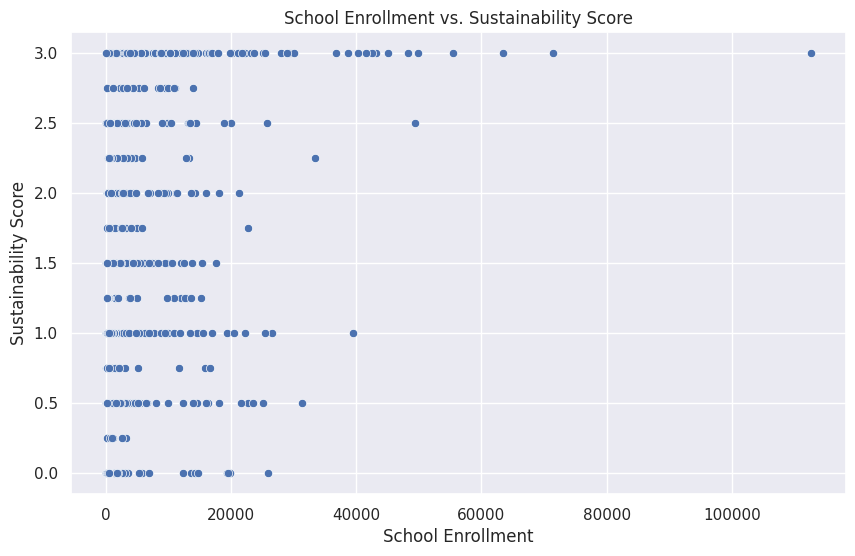

In [ ]:
# plot school enrollment against sustainability score
ax = sns.scatterplot(df_scale, x='2023-24 Student Enrollment', y='District-Wide Campus Sustainability Indicators (up to 3)')
plt.title('School Enrollment vs. Sustainability Score')
plt.xlabel('School Enrollment')
plt.ylabel('Sustainability Score')
sns.set_theme(rc={'figure.figsize':(10, 6)})